In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import Normal as norm_dist
from torch.utils.data import DataLoader
from argparse import Namespace

from unified_path.action import Action, MGM
from unified_path.models.realNVP import load_RealNVP, transfer_path_flow_to_normal_flow
from unified_path.loss import load_loss
from unified_path.utils import gather_grads, infinite_sampling

from notebook_utils import plot_action

Let us create a minimal 2D example with few samples and visualize it

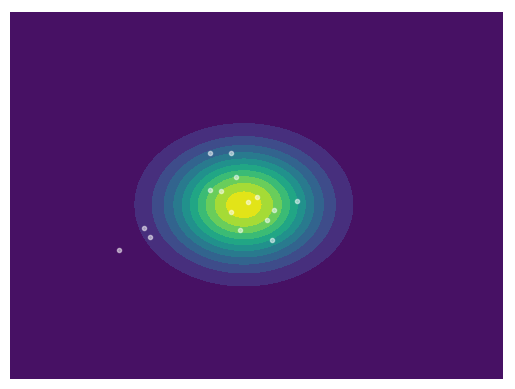

In [10]:
target_action = MGM(cluster_loc=0.2, cluster_scale=0.5, clusters=1)
n = 16
torch.manual_seed(0)
test_data = target_action.sample((512,))
train_data = target_action.sample((n,))

plot_action(target_action, train_data=train_data);

As we can see it is a simple Gaussian. The generated samples have some outlier.
Let us next create a RealNVP, which we will train with Maximum Likelihood on the generated training points.
The flow is also very small, it has 3 coupling layers, with 2 hidden layers with width 64 each.
We only train for 500 epochs with full batch size.

## Maximum Likelihood versus Path Gradients for the forward KL

In [3]:
from mgm_train import train

cfg = Namespace(nsamples=n, 
            gradient_estimator="ML", 
            dim=2,
            n_coupling_layers=3,
            n_blocks=2, 
            hidden=64,
            device="cpu",
            batch_size=n,
            lat_shape=[2],
            steps=500,
               )


def train_from_config(cfg):
    torch.manual_seed(0)
    flow = load_RealNVP(cfg)

    
    config_sampler = infinite_sampling(
            DataLoader(
                train_data, batch_size=cfg.batch_size, shuffle=True, drop_last=False
            )
        )
    loss = load_loss(cfg, flow, target_action, "cpu", config_sampler=config_sampler)
    train(
        flow=flow,
        train_data=train_data,
        test_data=test_data,
        kl=loss,
        steps=cfg.steps,
        batch_size=cfg.batch_size,
    );
    
    plot_action(target_action, flow, train_data=train_data)
    return flow

  0%|          | 0/500 [00:00<?, ?it/s]

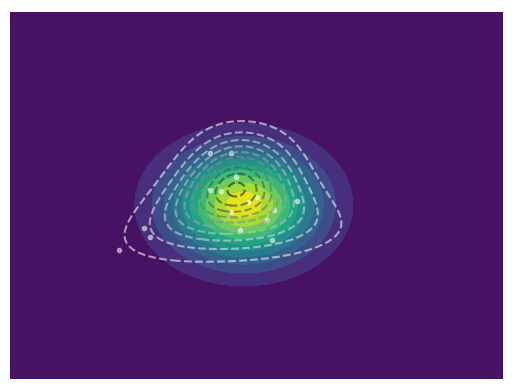

In [4]:
# Training with Maximum Likelihood
train_from_config(cfg);

We can see the Maximum likelihood estimator overfits on the outliers of the training set. 
We can also see the neg loglikelihood for the training and test set diverge.
Let us train with path gradients next.

  0%|          | 0/500 [00:00<?, ?it/s]

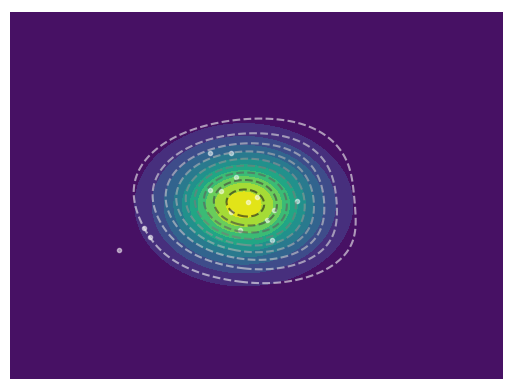

In [5]:
# Training with Path Gradients
cfg.gradient_estimator = "fastPathPQ"
realNVPFastPath = train_from_config(cfg);

The path gradient estimators do no exhibit this overfitting behavior.
Next let us look at the efficient recursive computation of the path gradients.

## Piggyback gradients

In order to confirm, that the recursive equations actually compute the gradients
$
\frac{\partial \log q_\theta(x)}{\partial x} \, ,
$
let us create a copy and confirm, that the gradients are equivalent.

First we create a pair of RealNVP with identical parameters. One is a standard RealNVP, the other is the implementation for efficient path gradients. For the latter every coupling block is wrapped in order to piggy back the gradients along with the forward pass

In [6]:
cfg.gradient_estimator = "ML"
realNVPStandard = load_RealNVP(cfg)

transfer_path_flow_to_normal_flow(realNVPStandard, realNVPFastPath)

eps = realNVPStandard.sample_base(n)
# Check that both give the same result
xStd, logqEpsStd = realNVPStandard(eps)
xPath, logqEpsPath = realNVPFastPath(eps)
assert torch.allclose(xStd, xPath)
assert torch.allclose(logqEpsStd, logqEpsPath)

Now that we have created a pair of samples and have confirmed that they behave identical, let us compare the gradient computation.
We start with the standard way. Do one forward pass to get $x$ and then compute the log probability $\log q_\theta(x)$ and the force $\nabla_x \log q_\theta(x)$.

In [7]:
# Compute gradients in the standard way

# Forward pass
x = realNVPStandard(eps)[0].detach().clone().requires_grad_()

# Backward pass
_, logqX = realNVPStandard.reverse(x)

# Compute gradients
dlogqXdX = torch.autograd.grad(logqX.sum(), x)[0]

To apply the recursive equations for computing the force $\nabla_x \log q_\theta(x)$, we first have to compute initial value $\nabla_\epsilon \log q_0(\epsilon)$. We then call the function implementing the piggy back gradient computation

In [8]:
# Compute gradients with recursive equations

# Setting up initial values
eps = eps.requires_grad_()
logq0Eps = realNVPStandard._base_log_prob(eps)
dlogq0EpsdEps = torch.autograd.grad(logq0Eps.sum(), eps)[0]

# Simultaneously do forward pass and calculation of force
x_pb, logdet_pb, dlogqXdX_pb =  realNVPFastPath.piggy_back_forward(eps, dlogq0EpsdEps)

In [9]:
assert torch.allclose(x_pb, x)
assert torch.allclose(dlogqXdX, dlogqXdX_pb)
assert torch.allclose(logq0Eps + logdet_pb, logqX)